## Load Dataset

In [47]:
import pandas as pd
nput_csv_path = 'out7th.csv'
column_b_df = pd.read_csv(input_csv_path, usecols=[1])
output_csv_path = 'output_column_b.csv'  # Replace with your desired output file path
df = pd.DataFrame(column_b_df.values, columns=['Column1'])
df['Column1'] = pd.to_numeric(df['Column1'].str.strip("[]'"))
df.to_csv(output_csv_path, index=False)



In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

[[-0.04 ]
 [-0.036]
 [-0.049]
 ...
 [-0.042]
 [-0.041]
 [-0.045]]


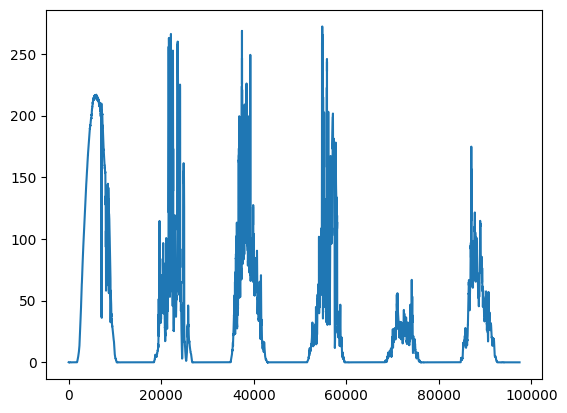

In [49]:

training_set = pd.read_csv('output_column_b.csv')
training_set= training_set.values
print(training_set)
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

In [50]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
print(dataY)

tensor([[0.0005],
        [0.0005],
        [0.0005],
        ...,
        [0.0005],
        [0.0004],
        [0.0005]])


## Model

In [51]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

## Training

In [52]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.11386
Epoch: 100, loss: 0.00081
Epoch: 200, loss: 0.00057
Epoch: 300, loss: 0.00044
Epoch: 400, loss: 0.00034
Epoch: 500, loss: 0.00027
Epoch: 600, loss: 0.00022
Epoch: 700, loss: 0.00017
Epoch: 800, loss: 0.00015
Epoch: 900, loss: 0.00014
Epoch: 1000, loss: 0.00013
Epoch: 1100, loss: 0.00012
Epoch: 1200, loss: 0.00012
Epoch: 1300, loss: 0.00011
Epoch: 1400, loss: 0.00010
Epoch: 1500, loss: 0.00010
Epoch: 1600, loss: 0.00009
Epoch: 1700, loss: 0.00009
Epoch: 1800, loss: 0.00009
Epoch: 1900, loss: 0.00008


Prediction and Plotting



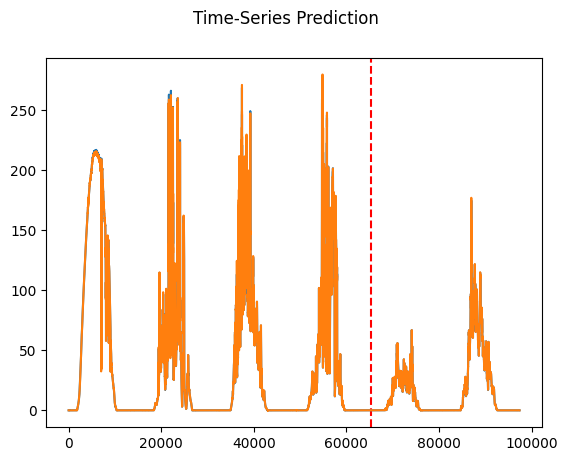

In [53]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()